## Get packages

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor  # Import XGBoost models
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, roc_auc_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
import logging

## Import and pre-process data

In [105]:
# Load the dataset
data = pd.read_csv('data/data_clean.csv')
# Use pd.get_dummies to one-hot encode the 'industry' column and any other categorical columns
data = pd.get_dummies(data, columns=['industry'], drop_first=True)

In [106]:
# Encode the 'stage_grouped' column using LabelEncoder if it is of object type
data['stage_grouped'] = data['stage_grouped'].apply(lambda x: 1 if x == 'won' else 0)
data.head()

,customer_number,stage_grouped,max_closed_date,cloud_revenue,total_opp_amount,employees,country,ee_count,contacts_count,non_ee_count,...,industry_Maritime,industry_Medical Device,industry_Medical Devices,industry_Military/Defense,industry_Non-Traditional Sectors,industry_Other,industry_Retail,industry_Service Bureau / Engineering Services,industry_Technology,industry_Telecommunications
0,11325,0,8/15/24,15487.00,10497.00,850,UNITED STATES,4,70,31,...,False,False,False,False,False,False,False,False,False,False
1,11329,1,7/31/24,999.00,999.00,2683,UNITED STATES,17,301,85,...,False,False,False,False,False,False,False,False,False,False
2,11336,1,7/25/24,72231.75,72231.75,1893,UNITED STATES,55,241,85,...,False,False,False,False,False,False,False,False,False,False
3,11816,1,3/31/24,45747.30,154342.39,5000,UNITED STATES,23,85,26,...,False,False,False,False,False,False,False,False,False,False
4,11872,0,11/7/23,15000.00,15000.00,129,UNITED STATES,21,115,50,...,False,False,False,False,False,False,False,False,False,False


In [107]:
# Columns to drop
columns_to_drop = ['customer_number','stage_grouped','max_closed_date','cloud_revenue','total_opp_amount','country']

# Split the data into features and target for classification
X_class = data.drop(columns=columns_to_drop)
y_class = data['stage_grouped']

# Split the data into features and target for regression
X_reg = data.drop(columns=columns_to_drop)
y_reg = data['total_opp_amount']

# Standardize the features
scaler = StandardScaler()
X_class = scaler.fit_transform(X_class)
X_reg = scaler.fit_transform(X_reg)

## Quick logistic test (baseline)

In [108]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Create and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

(618, 59) (265, 59) (618,) (265,)
              precision    recall  f1-score   support

           0       0.60      0.70      0.65       135
           1       0.62      0.51      0.56       130

    accuracy                           0.61       265
   macro avg       0.61      0.61      0.60       265
weighted avg       0.61      0.61      0.60       265



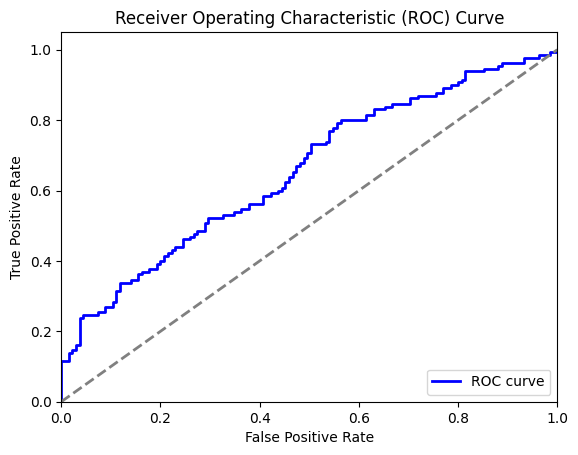

AUC: 0.6564672364672366


In [109]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc}')

## Analyze features

In [110]:
# Feature names
features = data.drop(columns=columns_to_drop).columns

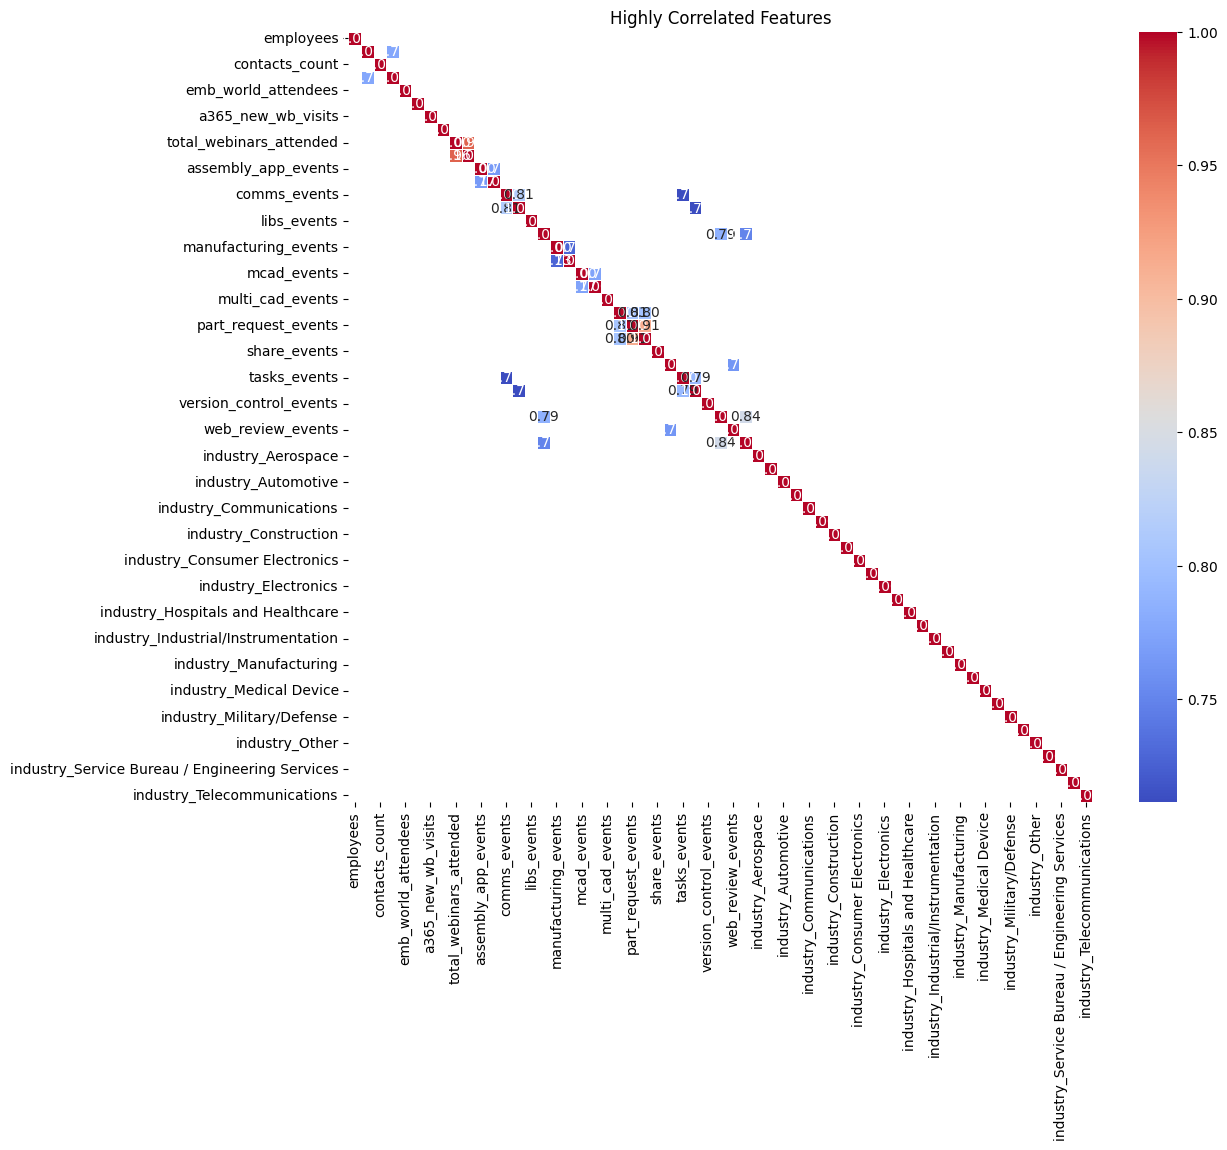

In [111]:
# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_class, columns=features).corr()

# Filter the correlation matrix to show only highly correlated features
high_corr = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]

# Plot the heatmap for highly correlated features
plt.figure(figsize=(12, 10))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Highly Correlated Features")
plt.show()

In [112]:
# List out the highly correlated features and what they are correlated with
high_corr_features = []
for i in range(len(high_corr.columns)):
    for j in range(i):
        if abs(high_corr.iloc[i, j]) > 0.7:
            high_corr_features.append((high_corr.columns[i], high_corr.columns[j], high_corr.iloc[i, j]))

# Sort the list by the absolute value of the correlation in descending order
high_corr_features = sorted(high_corr_features, key=lambda x: abs(x[2]), reverse=True)
high_corr_features

[('total_webinar_attendees',
  'total_webinars_attended',
  np.float64(0.961838715638132)),
 ('part_request_days_used',
  'part_request_events',
  np.float64(0.9130715077570689)),
 ('web_review_days_used',
  'version_control_days_used',
  np.float64(0.8430530272699605)),
 ('comms_days_used', 'comms_events', np.float64(0.8144829419463917)),
 ('part_request_events',
  'multi_cad_days_used',
  np.float64(0.8052464982944997)),
 ('part_request_days_used',
  'multi_cad_days_used',
  np.float64(0.8027161690891133)),
 ('tasks_days_used', 'tasks_events', np.float64(0.7938076192629054)),
 ('version_control_days_used',
  'libs_days_used',
  np.float64(0.7852773453664954)),
 ('non_ee_count', 'ee_count', np.float64(0.776376570147556)),
 ('mcad_days_used', 'mcad_events', np.float64(0.7729324106302644)),
 ('assembly_app_days_used',
  'assembly_app_events',
  np.float64(0.7658879131705919)),
 ('web_review_events', 'share_days_used', np.float64(0.7633798331305925)),
 ('web_review_days_used', 'libs_days

In [113]:
# Create list of features to drop
features_to_drop = ['share_days_used','web_review_days_used','manufacturing_days_used','tasks_days_used','non_ee_count','mcad_days_used','assembly_app_days_used','comms_events','total_webinar_attendees','part_request_days_used','version_control_days_used','multi_cad_days_used']
#features_to_drop = []

# Remove features from X_class and X_reg that are highly correlated with other features
X_class = data.drop(columns=features_to_drop + columns_to_drop)
X_reg = data.drop(columns=features_to_drop + columns_to_drop)

In [114]:
# List high correlation features again
# Calculate the correlation matrix
correlation_matrix = pd.DataFrame(X_class, columns=features).corr()

# Filter the correlation matrix to show only highly correlated features
high_corr = correlation_matrix[(correlation_matrix > 0.7) | (correlation_matrix < -0.7)]

# List out the highly correlated features and what they are correlated with
high_corr_features = []
for i in range(len(high_corr.columns)):
    for j in range(i):
        if abs(high_corr.iloc[i, j]) > 0.7:
            high_corr_features.append((high_corr.columns[i], high_corr.columns[j], high_corr.iloc[i, j]))

# Sort the list by the absolute value of the correlation in descending order
high_corr_features = sorted(high_corr_features, key=lambda x: abs(x[2]), reverse=True)
high_corr_features


[]

In [115]:
# Correlation Analysis to see how features correlate with the target
print("Correlation Analysis:")
correlation_matrix = pd.DataFrame(X_class, columns=data.drop(columns=columns_to_drop + features_to_drop).columns).corrwith(pd.Series(y_class)).abs()
print(correlation_matrix.sort_values(ascending=False))

Correlation Analysis:
libs_days_used                                     0.227639
comms_days_used                                    0.131746
web_review_events                                  0.116191
version_control_events                             0.108136
a365_rest_wb_visits                                0.101293
industry_Aerospace                                 0.093700
mcad_events                                        0.093545
multi_cad_events                                   0.079669
tasks_events                                       0.078125
manufacturing_events                               0.077596
part_request_events                                0.077008
assembly_app_events                                0.070631
total_webinars_attended                            0.064571
industry_Component OEM                             0.051867
industry_Maritime                                  0.047121
industry_Engineering                               0.043841
industry_Service B

In [116]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Recursive Feature Elimination (RFE) to select the top 15 most important features
print("Recursive Feature Elimination (RFE):")
rfe_classifier = RFE(estimator=LogisticRegression(max_iter=1000000), n_features_to_select=15)
X_train_rfe = rfe_classifier.fit_transform(X_train_class, y_train_class)
X_test_rfe = rfe_classifier.transform(X_test_class)

# Get the names of the selected features
selected_features = X_class.columns[rfe_classifier.support_]
print(f"Selected Features: {selected_features}")

Feature Importance from Random Forest:


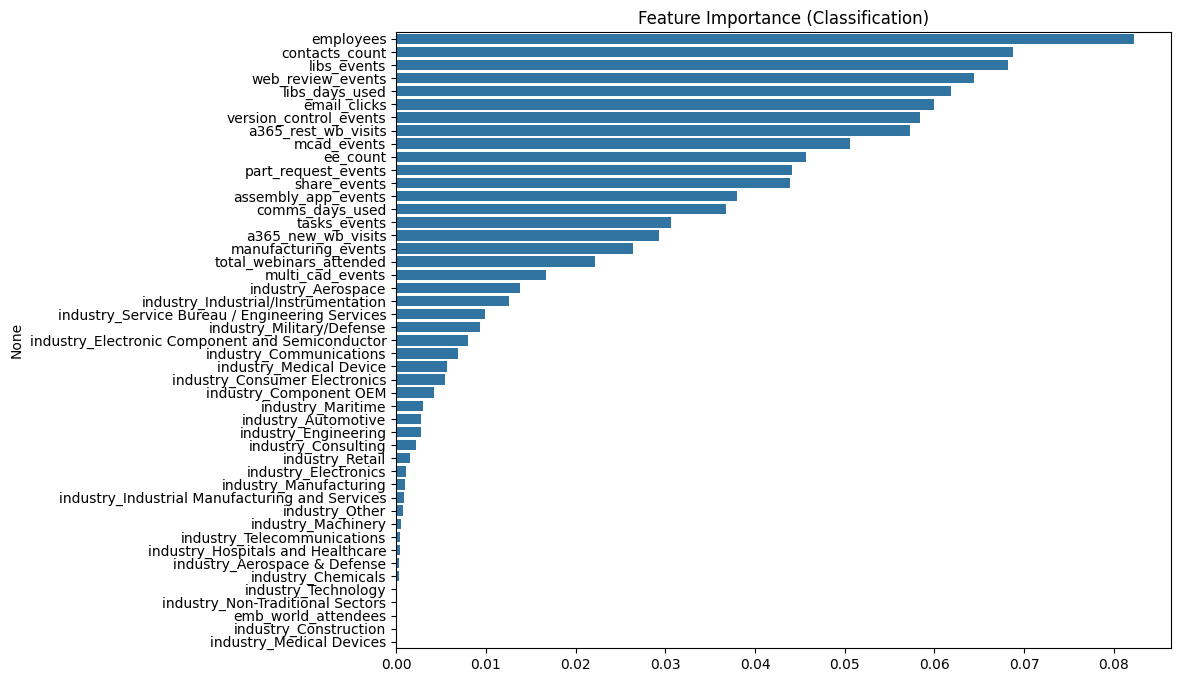

In [117]:
# Feature importance using a Random Forest classifier to see which features are most important
print("Feature Importance from Random Forest:")
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_class, y_train_class)
importances = rf_classifier.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = data.drop(columns=features_to_drop + columns_to_drop).columns[indices]

# Plot feature importances as a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Feature Importance (Classification)")
plt.show()

Feature Importance from XGBoost:


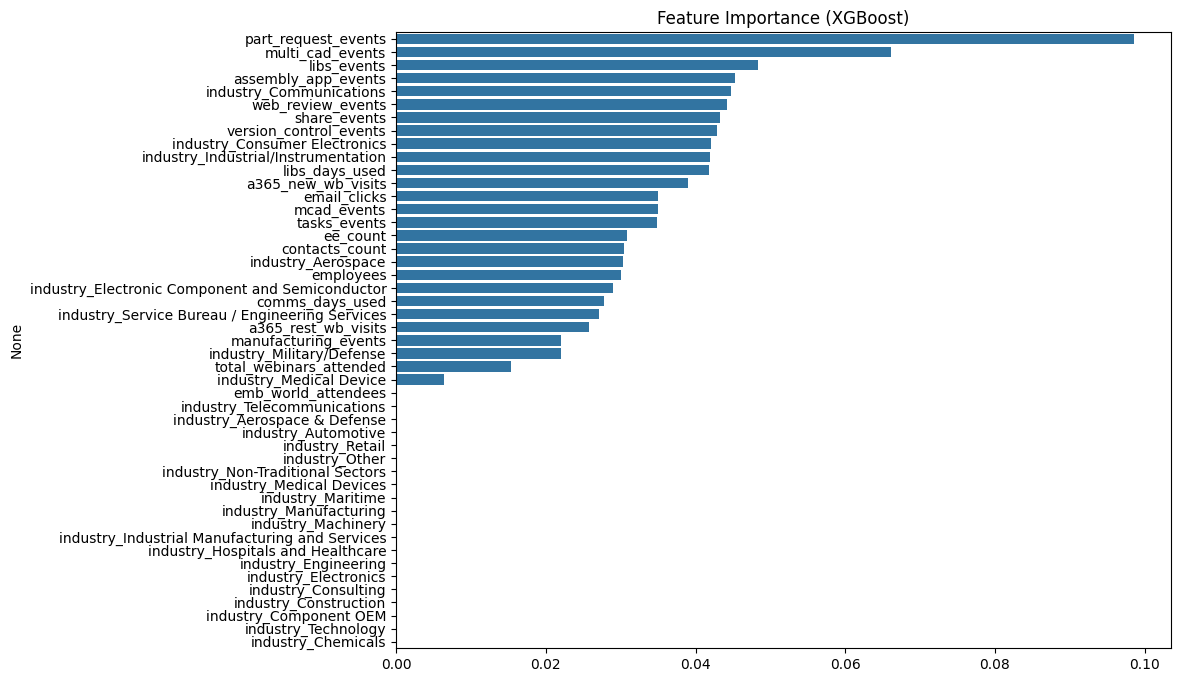

In [118]:
# Feature Importance using XGBoost
print("Feature Importance from XGBoost:")
xgb_classifier = XGBClassifier(eval_metric='logloss')
xgb_classifier.fit(X_train_class, y_train_class)
importances_xgb = xgb_classifier.feature_importances_

# Sort the feature importances in descending order
indices_xgb = np.argsort(importances_xgb)[::-1]
sorted_importances_xgb = importances_xgb[indices_xgb]
sorted_features_xgb = data.drop(columns=features_to_drop + columns_to_drop).columns[indices_xgb]

# Plot XGBoost feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances_xgb, y=sorted_features_xgb)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [119]:
# PCA (Principal Component Analysis) to reduce dimensionality while retaining 95% of the variance
print("Principal Component Analysis (PCA):")
pca = PCA(n_components=0.98)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_class)
X_test_pca = pca.transform(X_test_class)
print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_)}")

Principal Component Analysis (PCA):
Number of components selected: 4
Explained variance ratio: [0.36870773 0.35153189 0.22761817 0.04642475]
Total explained variance: 0.9942825446155708


In [120]:
# Get the components (loadings) of the PCA
components = pca.components_

# Create a DataFrame to see the contribution of each feature to each principal component
pca_df = pd.DataFrame(components, columns=X_class.columns.tolist())
print("\nContribution of each feature to the principal components:")
print(pca_df)


Contribution of each feature to the principal components:
   employees  ee_count  contacts_count  emb_world_attendees  email_clicks  \
0   0.375839  0.000087        0.000859         6.330004e-08      0.000635   
1   0.925426 -0.000006       -0.000097        -5.220301e-08     -0.000303   
2   0.044921  0.000202        0.001842         1.525246e-07      0.001777   
3  -0.017025  0.000225        0.003165         5.254369e-07      0.003781   

   a365_new_wb_visits  a365_rest_wb_visits  total_webinars_attended  \
0            0.000167             0.001388                 0.000013   
1           -0.000044            -0.000388                -0.000008   
2            0.000320             0.003880                 0.000038   
3            0.000477             0.000630                 0.000037   

   assembly_app_events  comms_days_used  ...  industry_Maritime  \
0             0.000995         0.000673  ...      -2.061662e-07   
1            -0.001373        -0.000364  ...      -7.555822e-08  

In [ ]:
# Run logistic regression with pca features
logistic_model_pca = LogisticRegression()
logistic_model_pca.fit(X_train_pca, y_train_class)

# Make predictions
y_pred_pca = logistic_model_pca.predict(X_test_pca)

# Evaluate the model
print(classification_report(y_test_class, y_pred_pca))

# Calculate the AUC
roc_auc_pca = roc_auc_score(y_test_class, logistic_model_pca.predict_proba(X_test_pca)[:, 1])
print(f'AUC: {roc_auc_pca}')

              precision    recall  f1-score   support

           0       0.56      0.89      0.69       135
           1       0.71      0.28      0.41       130

    accuracy                           0.59       265
   macro avg       0.64      0.59      0.55       265
weighted avg       0.64      0.59      0.55       265

AUC: 0.6283190883190882


## Create metrics table

In [123]:
# Dictionary to store the metrics for each model
metrics_table = {
    'Model': [],
    'Best Parameters': [],
    'Accuracy': [],
    'AUC': [],
    'MSE': [],
    'R2 Score': []
}

In [124]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

## Perform classification modeling

In [125]:
# Classification Models with Hyperparameter Tuning
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

for name, model in classifiers.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train_class)
    best_model = grid_search.best_estimator_
    y_pred_class = best_model.predict(X_test)
    y_prob_class = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_class, y_pred_class)
    auc = roc_auc_score(y_test_class, y_prob_class)
    mse = None  # Not applicable for classification
    r2 = None   # Not applicable for classification
    
    # Store metrics in the table
    metrics_table['Model'].append(name)
    metrics_table['Best Parameters'].append(grid_search.best_params_)
    metrics_table['Accuracy'].append(accuracy)
    metrics_table['AUC'].append(auc)
    metrics_table['MSE'].append(mse)
    metrics_table['R2 Score'].append(r2)

In [126]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table).sort_values(by='AUC', ascending=False)
metrics_table_sorted

,Model,Best Parameters,Accuracy,AUC,MSE,R2 Score
1,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.649057,0.718291,None,None
2,SVM,"{'C': 1, 'kernel': 'linear'}",0.600000,0.666866,None,None
4,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.592453,0.650028,None,None
0,Logistic Regression,{'C': 0.01},0.618868,0.641652,None,None
3,K-Nearest Neighbors,{'n_neighbors': 9},0.569811,0.614387,None,None


In [127]:
# Deep Learning Classification Model
print("\nDeep Learning Classification:")
model_class = Sequential()
model_class.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_class.add(Dense(32, activation='relu'))
model_class.add(Dense(1, activation='sigmoid'))
model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_class.fit(X_train, y_train_class, epochs=50, batch_size=10, verbose=1)

# Evaluate the deep learning classification model
loss, accuracy = model_class.evaluate(X_test, y_test_class)
y_prob_class_dl = model_class.predict(X_test).flatten()
auc = roc_auc_score(y_test_class, y_prob_class_dl)
mse = None  # Not applicable for classification
r2 = None   # Not applicable for classification

# Store deep learning classification metrics in the table
metrics_table['Model'].append("Deep Learning (Classification)")
metrics_table['Best Parameters'].append(None)
metrics_table['Accuracy'].append(accuracy)
metrics_table['AUC'].append(auc)
metrics_table['MSE'].append(mse)
metrics_table['R2 Score'].append(r2)


Deep Learning Classification:
Epoch 1/50


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.5505 - loss: 0.7079
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.6400 - loss: 0.6462
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step - accuracy: 0.6575 - loss: 0.6320
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - accuracy: 0.6489 - loss: 0.6092
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - accuracy: 0.6444 - loss: 0.6095
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.7325 - loss: 0.5625
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step - accuracy: 0.7022 - loss: 0.5649
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7084 - loss: 0.5505
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.7394 - loss: 0.5475
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.7435 - loss: 0.5487
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.7334 - loss: 0.5127
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy

In [128]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table).sort_values(by='AUC', ascending=False)
metrics_table_sorted

,Model,Best Parameters,Accuracy,AUC,MSE,R2 Score
1,Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.649057,0.718291,None,None
2,SVM,"{'C': 1, 'kernel': 'linear'}",0.600000,0.666866,None,None
4,XGBoost,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.592453,0.650028,None,None
5,Deep Learning (Classification),None,0.603774,0.648262,None,None
0,Logistic Regression,{'C': 0.01},0.618868,0.641652,None,None
3,K-Nearest Neighbors,{'n_neighbors': 9},0.569811,0.614387,None,None


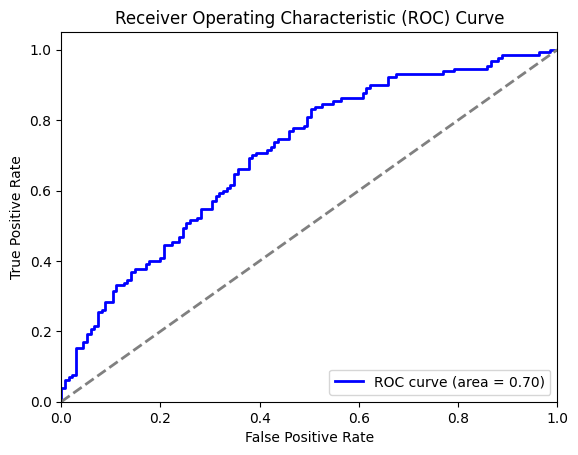

In [129]:
from sklearn.metrics import roc_curve, auc

# Fit the best Random Forest model
best_rf_model = RandomForestClassifier(max_depth=10, n_estimators=200)
best_rf_model.fit(X_train_class, y_train_class)

# Predict probabilities
y_prob_rf = best_rf_model.predict_proba(X_test_class)[:, 1]

# Calculate the ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_class, y_prob_rf)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [130]:
from sklearn.metrics import roc_curve, auc

# Example: Assuming y_test and y_prob_rf are defined
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)  # y_test: True labels, y_prob_rf: Predicted probabilities
roc_auc_rf = auc(fpr_rf, tpr_rf)

print("AUC for Random Forest:", roc_auc_rf)


AUC for Random Forest: 0.7039316239316239


## Perform regression modeling

In [95]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Regression Models with Hyperparameter Tuning
regressors = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

param_grid_reg = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
}

logger.info("\nRegression Results with Hyperparameter Tuning:")
for name, model in regressors.items():
    logger.info(f"Training {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid_reg[name], scoring='r2', cv=5)
    grid_search.fit(X_train_reg, y_train_reg)
    best_model = grid_search.best_estimator_
    y_pred_reg = best_model.predict(X_test_reg)
    
    # Calculate metrics
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)
    accuracy = None  # Not applicable for regression
    auc = None       # Not applicable for regression
    
    # Store metrics in the table
    metrics_table['Model'].append(name)
    metrics_table['Best Parameters'].append(grid_search.best_params_)
    metrics_table['Accuracy'].append(accuracy)
    metrics_table['AUC'].append(auc)
    metrics_table['MSE'].append(mse)
    metrics_table['R2 Score'].append(r2)
    
    logger.info(f"Completed {name}. Best Parameters: {grid_search.best_params_}, MSE: {mse}, R2: {r2}")

INFO:__main__:
Regression Results with Hyperparameter Tuning:
INFO:__main__:Training Linear Regression...
INFO:__main__:Completed Linear Regression. Best Parameters: {}, MSE: 4062742650.244498, R2: -3.360856838565825
INFO:__main__:Training Random Forest...
INFO:__main__:Completed Random Forest. Best Parameters: {'max_depth': None, 'n_estimators': 100}, MSE: 2750883838.3311586, R2: -1.9527370132008492
INFO:__main__:Training XGBoost...
INFO:__main__:Completed XGBoost. Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}, MSE: 2174798525.2274027, R2: -1.3343799589841212


In [96]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table).sort_values(by='R2 Score', ascending=False)
metrics_table_sorted

,Model,Best Parameters,Accuracy,AUC,MSE,R2 Score
8,K-Nearest Neighbors,{'n_neighbors': 9},NaN,NaN,1.274610e+09,-0.368138
9,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",NaN,NaN,2.174799e+09,-1.334380
12,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",NaN,NaN,2.174799e+09,-1.334380
11,Random Forest,"{'max_depth': None, 'n_estimators': 100}",NaN,NaN,2.750884e+09,-1.952737
7,Random Forest,"{'max_depth': None, 'n_estimators': 100}",NaN,NaN,2.759325e+09,-1.961797
6,Linear Regression,{},NaN,NaN,4.062743e+09,-3.360857
10,Linear Regression,{},NaN,NaN,4.062743e+09,-3.360857
0,Logistic Regression,{'C': 0.01},0.618868,0.641652,NaN,NaN
1,Random Forest,"{'max_depth': 20, 'n_estimators': 50}",0.645283,0.724330,NaN,NaN
2,SVM,"{'C': 1, 'kernel': 'linear'}",0.600000,0.666895,NaN,NaN


In [97]:
# Deep Learning Regression Model
print("\nDeep Learning Regression:")

# Ensure the input data is in the correct format
X_train_reg = np.array(X_train_reg).astype(np.float32)
y_train_reg = np.array(y_train_reg).astype(np.float32)
X_test_reg = np.array(X_test_reg).astype(np.float32)
y_test_reg = np.array(y_test_reg).astype(np.float32)

# Building the deep learning model for regression
model_reg = Sequential()
model_reg.add(Dense(64, input_dim=X_train_reg.shape[1], activation='relu'))  # First hidden layer with 64 neurons and ReLU activation
model_reg.add(Dense(32, activation='relu'))  # Second hidden layer with 32 neurons and ReLU activation
model_reg.add(Dense(1))  # Output layer with 1 neuron (no activation for regression)

# Compile the model using mean squared error loss and the Adam optimizer
model_reg.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data
model_reg.fit(X_train_reg, y_train_reg, epochs=50, batch_size=10, verbose=1)  # Train for 50 epochs with a batch size of 10

# Evaluate the model on the test data
y_pred_reg_dl = model_reg.predict(X_test_reg).flatten()  # Make predictions and flatten the output
mse = mean_squared_error(y_test_reg, y_pred_reg_dl)  # Calculate mean squared error
r2 = r2_score(y_test_reg, y_pred_reg_dl)  # Calculate R2 score
accuracy = None  # Not applicable for regression
auc = None       # Not applicable for regression

# Store deep learning regression metrics in the table
metrics_table['Model'].append("Deep Learning (Regression)")
metrics_table['Best Parameters'].append(None)  # No hyperparameters to report
metrics_table['Accuracy'].append(accuracy)
metrics_table['AUC'].append(auc)
metrics_table['MSE'].append(mse)
metrics_table['R2 Score'].append(r2)


Deep Learning Regression:
Epoch 1/50


/Users/bluebird/develop/15.071-the-analytics-edge/envedge/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 6934703104.0000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 7454478848.0000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 4765174784.0000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 4944730624.0000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 5311304704.0000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 7315917312.0000 
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 3454401024.0000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 7582601728.0000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 3887029248.0000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 10715867136.0000
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 3533016064.0000
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 7811155968.0000 
Epoch 13/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 2483122432.0000
Epoch 14/50
62/6

In [98]:
pd.DataFrame(metrics_table)
metrics_table_sorted = pd.DataFrame(metrics_table).sort_values(by='R2 Score', ascending=False)
metrics_table_sorted

,Model,Best Parameters,Accuracy,AUC,MSE,R2 Score
13,Deep Learning (Regression),None,NaN,NaN,9.677284e+08,-0.038738
8,K-Nearest Neighbors,{'n_neighbors': 9},NaN,NaN,1.274610e+09,-0.368138
9,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",NaN,NaN,2.174799e+09,-1.334380
12,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",NaN,NaN,2.174799e+09,-1.334380
11,Random Forest,"{'max_depth': None, 'n_estimators': 100}",NaN,NaN,2.750884e+09,-1.952737
7,Random Forest,"{'max_depth': None, 'n_estimators': 100}",NaN,NaN,2.759325e+09,-1.961797
6,Linear Regression,{},NaN,NaN,4.062743e+09,-3.360857
10,Linear Regression,{},NaN,NaN,4.062743e+09,-3.360857
0,Logistic Regression,{'C': 0.01},0.618868,0.641652,NaN,NaN
1,Random Forest,"{'max_depth': 20, 'n_estimators': 50}",0.645283,0.724330,NaN,NaN
